In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from jury import Jury
from jury.metrics import Bleu
sns.set(style="whitegrid")


## Load Data
Load result CSV files for each task and model.

In [19]:

csv_files = {
    "assessment_llaqo": "checkpoint_963000.csv",
    "assessment_ltu": "ltu_results.csv",
    "assessment_mullama": "mullama_results.csv",
    "difficulty_llaqo": "checkpoint_960000_cipi.csv",
    "difficulty_ltu": "ltu_results_cipi.csv",
    "difficulty_mullama": "mullama_results_cipi.csv",
    "techniques_llaqo": "checkpoint_960000_techniques.csv",
    "techniques_ltu": "ltu_results_techniques.csv",
    "techniques_mullama": "mullama_results_techniques.csv"
}

# Load dataframes
dataframes = {key: pd.read_csv(path) for key, path in csv_files.items()}


## Assessment Task Analysis
For assessment, we calculate MAE for rating questions and use NLP metrics for verbal assessments.


In [20]:

def calculate_assessment_metrics(df):
    # Initialize Jury with specified metrics
    scorer = Jury(metrics=["bertscore", "meteor", "rouge"])
    bleu = Bleu.construct()

    # Calculate Prompt Following Rate (PFR)
    df['validity'] = df['mae'].notna().astype(int)
    prompt_following_rate = df['validity'].mean()

    # Calculate MAE only for valid entries where MAE is available
    valid_mae = df[df['mae'].notna()]['mae']
    mae_mean = valid_mae.mean() if not valid_mae.empty else None
    mae_std = valid_mae.std() if not valid_mae.empty else None

    # Prepare data for NLP metrics calculation
    predictions = df['verbal_output'].tolist()
    references = [[ref] for ref in df['verbal_gt'].tolist()]  # Jury expects list of list for references

    # Calculate NLP metrics
    nlp_scores = scorer(predictions=predictions, references=references)
    bleu_scores = bleu.compute(predictions=[eval(p) for p in predictions], references=references)

    print(bleu_scores)
    # Extract individual NLP scores and average BLEU score
    bleu_scores = [bleu_scores[f'bleu_{i}']['score'] for i in range(1, 5)]
    avg_bleu_score = np.mean(bleu_scores)

    nlp_result = {
        'bertscore': nlp_scores['bertscore']['f1'],
        'bleu': avg_bleu_score,
        'meteor': nlp_scores['meteor']['score'],
        'rougeL': nlp_scores['rouge']['rougeL']
    }

    return {
        'PFR': prompt_following_rate,
        'MAE_MEAN': mae_mean,
        'MAE_STD': mae_std,
        **nlp_result
    }

# Assuming you've run the above function for each DataFrame
assessment_metrics = {
    "LLaQo Assessment": calculate_assessment_metrics(dataframes['assessment_llaqo']),
    "LTU Assessment": calculate_assessment_metrics(dataframes['assessment_ltu']),
    "MuLLaMA Assessment": calculate_assessment_metrics(dataframes['assessment_mullama'])
}

# Convert the dictionary to a DataFrame for nice table format in Jupyter
results_table = pd.DataFrame(assessment_metrics).T  # Transpose for better readability
results_table


/data/home/acw630/venvs/lam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'total_items': 136, 'empty_items': 0, 'bertscore': {'score': 0.8531788701520246, 'precision': [0.8392161726951599, 0.8517041206359863, 0.844632089138031, 0.8501549363136292, 0.8391525745391846, 0.8502695560455322, 0.8623393774032593, 0.8658944368362427, 0.850953996181488, 0.8544741868972778, 0.8373278379440308, 0.8368085026741028, 0.8471906185150146, 0.8418201804161072, 0.8542642593383789, 0.8374571800231934, 0.8404182195663452, 0.8186464309692383, 0.8356946110725403, 0.8401814103126526, 0.8095852136611938, 0.8197938203811646, 0.8344810009002686, 0.834439754486084, 0.8492962718009949, 0.8436180949211121, 0.8580992817878723, 0.8430349230766296, 0.8771293759346008, 0.8110682368278503, 0.8274844884872437, 0.8339490294456482, 0.8263816833496094, 0.8504948019981384, 0.8306355476379395, 0.8419852256774902, 0.8313132524490356, 0.8172304630279541, 0.8535661101341248, 0.8289873003959656, 0.8466827869415283, 0.8681793212890625, 0.7872006893157959, 0.8319563269615173, 0.8531435132026672, 0.83100

KeyError: 'bleu_1'

In [18]:
dataframes['assessment_llaqo']['verbal_output'][0]

"['The point is that the tempo is kept at the specified tempo.']"

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparative_analysis(df1, df2, df3, model_labels):
    # Make sure that 'question_id' and 'question_category' are treated as categorical data types
    df1['question_id'] = df1['question_id'].astype(str)
    df2['question_id'] = df2['question_id'].astype(str)
    df3['question_id'] = df3['question_id'].astype(str)
    
    df1['model'] = model_labels[0]
    df2['model'] = model_labels[1]
    df3['model'] = model_labels[2]
    
    # Combine the dataframes for easier plotting
    combined_df = pd.concat([df1, df2, df3])

    # Setup the figure and axes
    fig, ax = plt.subplots(3, 1, figsize=(15, 18))  # 3 rows, 1 column

    # First plot: Mean Absolute Error by Question ID
    sns.barplot(ax=ax[0], x='question_id', y='mae', hue='model', data=combined_df, estimator=np.mean, ci='sd', palette='coolwarm')
    ax[0].set_title('Mean Absolute Error by Question ID')
    ax[0].set_xlabel('Question ID')
    ax[0].set_ylabel('Mean Absolute Error')
    ax[0].legend(title='Model')
    ax[0].tick_params(axis='x', rotation=45)

    # Second plot: Mean Absolute Error by Question Category
    sns.barplot(ax=ax[1], x='question_category', y='mae', hue='model', data=combined_df, estimator=np.mean, ci='sd', palette='viridis')
    ax[1].set_title('Mean Absolute Error by Question Category')
    ax[1].set_xlabel('Question Category')
    ax[1].set_ylabel('Mean Absolute Error')
    ax[1].legend(title='Model')
    ax[1].tick_params(axis='x', rotation=45)

    # Third plot: Ground Truth Distribution by Question Category
    sns.histplot(ax=ax[2], data=combined_df, x='gt', hue='question_category', multiple="stack", palette='pastel', binwidth=1)
    ax[2].set_title('Distribution of Ground Truth Ratings by Question Category')
    ax[2].set_xlabel('Ground Truth Ratings')
    ax[2].set_ylabel('Count')
    ax[2].legend(title='Question Category')

    plt.tight_layout()
    plt.show()


plot_comparative_analysis(dataframes['assessment_llaqo'], dataframes['assessment_ltu'], dataframes['assessment_mullama'], ['LLaQo', 'LTU', 'MuLLaMA'])


## Difficulty Task Analysis
For difficulty, we focus on the calculation of MAE.

In [ ]:

# %%
def calculate_difficulty_metrics(df):
    df['mae'] = np.abs(df['rating'] - df['gt'])
    return df['mae'].mean(), df['mae'].std()

difficulty_metrics = {key: calculate_difficulty_metrics(df) for key, df in dataframes.items() if 'difficulty' in key}


(1.0, 1.0, 1.0, None)

## Techniques Task Analysis
Techniques require extracting classifications from text responses.


In [ ]:

def extract_techniques(response):
    # Mock function to extract techniques from response
    # Implement based on actual data and needed extraction logic
    return response.split()[-1]

def calculate_techniques_metrics(df):
    df['extracted_technique'] = df['response'].apply(extract_techniques)
    precision, recall, f1, _ = precision_recall_fscore_support(df['gt'], df['extracted_technique'], average='macro')
    return precision, recall, f1

techniques_metrics = {key: calculate_techniques_metrics(df) for key, df in dataframes.items() if 'techniques' in key}


## GT analysis

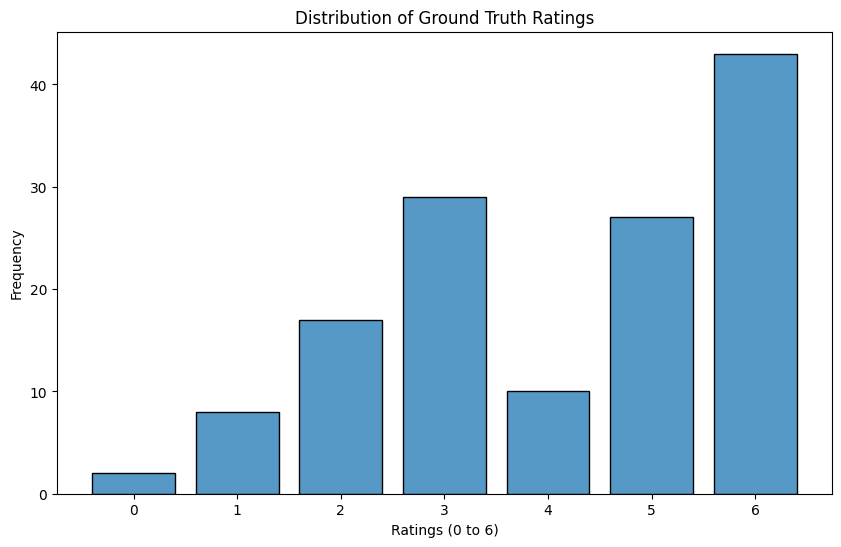

In [16]:

plt.figure(figsize=(10, 6))
sns.histplot(data=llaqo_df, x='gt', bins=range(8), kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.title('Distribution of Ground Truth Ratings')
plt.xlabel('Ratings (0 to 6)')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Ensure we have ticks for each rating from 0 to 6
plt.show()

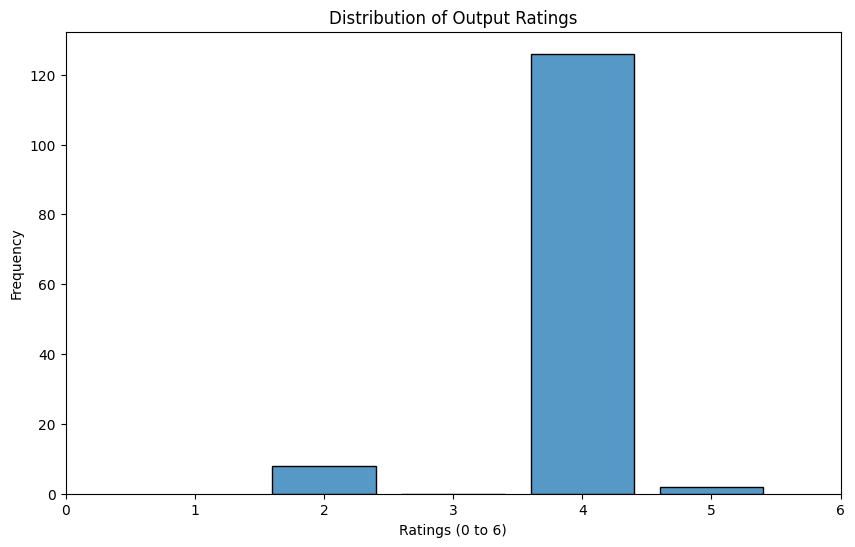

In [22]:

plt.figure(figsize=(10, 6))
sns.histplot(data=llaqo_df, x='output_rating',  bins=range(8), kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.title('Distribution of Output Ratings')
plt.xlabel('Ratings (0 to 6)')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Ensure we have ticks for each rating from 0 to 6
plt.show()

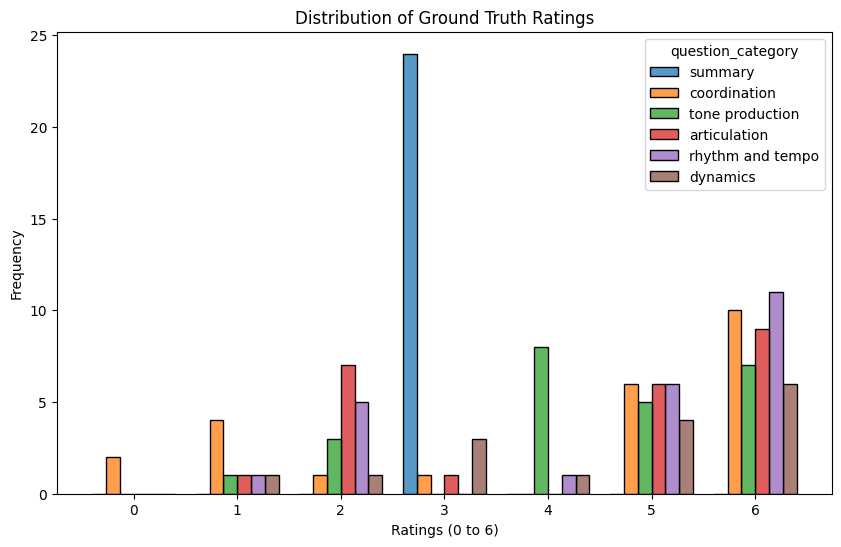

In [10]:

plt.figure(figsize=(10, 6))
sns.histplot(data=llaqo_df, x='gt', hue='question_category', bins=range(8), kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.title('Distribution of Ground Truth Ratings')
plt.xlabel('Ratings (0 to 6)')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Ensure we have ticks for each rating from 0 to 6
plt.show()